In [1]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive/')

Mounted at /content/drive/


In [21]:
model_weight_filepath = "drive/MyDrive/NLU Coursework/solution_B/models_B/solution_B.hdf5" #Path to the model weights to be demoed
model_arch_filepath = "drive/MyDrive/NLU Coursework/solution_B/models_B/solution_B.json" #Path to the model architecture to be demoed

dataset_path = "drive/MyDrive/NLU Coursework/data/training_data/training_data/NLI/dev.csv" #Path to the dataset used for evaluation
labels_path = "drive/MyDrive/NLU Coursework/submissions/Group_17_B.csv" #Path to output the predicted labels

# Evaluation Setup

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from transformers import XLNetTokenizer, XLNetModel

In [4]:
import json
from random import randint
import os
import random
from nltk.corpus import wordnet, stopwords
from itertools import chain
import nltk

In [5]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    precision_recall_fscore_support,
    log_loss,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt
import typing
import keras

@dataclass(frozen=True)
class GeneralKeys:
    """
    Dataclass for general keys for the process
    """

    PREMISE_KEY: str = "Premise"
    HYPOTHESIS_KEY: str = "Hypothesis"
    LABEL_KEY: str = "Label"
    LOSS_KEY: str = "Loss"
    PREDICTED_KEY: str = "Predicted Label"
    TRUE_KEY: str = "True Label"


@dataclass
class MacroMetric:
    """
    Dataclass for metrics that can be turned into macro & weighted macro
    """

    NORMAL_KEY: str
    MACRO_KEY: str
    WEIGHTED_KEY: str

    def __init__(self, key: str):
        self.NORMAL_KEY: str = key
        self.MACRO_KEY: str = f"Macro {key}"
        self.WEIGHTED_KEY: str = f"Weighted Macro {key}"


@dataclass(frozen=True)
class MetricKeys:
    """
    Dataclass associated with keys for the evaluation metrics
    """

    ACCURACY_KEY: str = "Accuracy"
    PRECISION: MacroMetric = MacroMetric(key="Precision")
    F1: MacroMetric = MacroMetric(key="F1-Score")
    RECALL: MacroMetric = MacroMetric(key="Recall")
    MCC_KEY: str = "MCC"
    LOSS_KEY: str = "Loss"


def evaluate(true_labels: np.array, predicted_logits: np.array) -> pd.DataFrame:
    """
    Uses the true and predicted labels & sklearn to create extensive evaluation metrics. Formats into a dataframe that it returns

    true_labels:        (N) sized array storing the true (0, 1) labels of the data
    predicted_logits:   (N, 2) sized array storing the predicted logits from the model, therefore the predicted probabilities for either class
    """
    loss = log_loss(true_labels, predicted_logits)  # Uses logits for loss

    # Otherwise utilises argmax of the prediction logits, to get the predicted labels
    predicted_labels = np.argmax(predicted_logits, axis=1)

    accuracy = accuracy_score(true_labels, predicted_labels)

    precision, recall, f1, support = precision_recall_fscore_support(
        true_labels, predicted_labels
    )

    weighted_precision = np.average(precision, weights=support)
    weighted_recall = np.average(recall, weights=support)
    weighted_f1 = np.average(f1, weights=support)

    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    macro_precision = precision_score(true_labels, predicted_labels, average="macro")
    macro_recall = recall_score(true_labels, predicted_labels, average="macro")
    macro_f1 = f1_score(true_labels, predicted_labels, average="macro")

    mcc = matthews_corrcoef(true_labels, predicted_labels)

    # Format into dataframe for easier viewing
    df = pd.DataFrame(
        [
            [
                accuracy,
                precision,
                macro_precision,
                weighted_precision,
                recall,
                macro_recall,
                weighted_recall,
                f1,
                macro_f1,
                weighted_f1,
                mcc,
                loss,
            ]
        ],
        columns=[
            MetricKeys.ACCURACY_KEY,
            MetricKeys.PRECISION.NORMAL_KEY,
            MetricKeys.PRECISION.MACRO_KEY,
            MetricKeys.PRECISION.WEIGHTED_KEY,
            MetricKeys.RECALL.NORMAL_KEY,
            MetricKeys.RECALL.MACRO_KEY,
            MetricKeys.RECALL.WEIGHTED_KEY,
            MetricKeys.F1.NORMAL_KEY,
            MetricKeys.F1.MACRO_KEY,
            MetricKeys.F1.WEIGHTED_KEY,
            MetricKeys.MCC_KEY,
            MetricKeys.LOSS_KEY,
        ],
    )
    return df


@dataclass
class ClassLabels:
    """
    Dataclass for the string class labels. Used in the confusion matrix generation
    """

    ZERO_KEY: str = "Not Entailing"
    ONE_KEY: str = "Entailing"


def draw_confusion_matrix(
    true_labels: np.array,
    predicted_logits: np.array,
    classes: typing.List[str] = [ClassLabels.ZERO_KEY, ClassLabels.ONE_KEY],
) -> np.array:
    """
    Will make a confusion matrix using the predicted and true values & will display this. Returns the confusion matrix as an array
    """
    predicted_labels = np.argmax(predicted_logits, axis=1)

    conf_mat = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
    disp.plot()
    plt.show()
    return conf_mat


def most_confused_samples(
    true_logits: np.array,
    predicted_logits: np.array,
    premises: typing.List[str],
    hypotheses: typing.List[str],
    num: int = 5,
    loss_function: callable = keras.losses.categorical_crossentropy,
) -> pd.DataFrame:
    """
    Will print the num samples with the highest loss

    true_logits:        (N, 2) sized array storing the one hot encoded labels of the data
    predicted_logits:   (N, 2) sized array storing the predicted logits from the model, therefore the predicted probabilities for either class
    premises:           (N) sized array storing the string premises
    hypotheses:         (N) sized array storing the string hypotheses

    num:                Integer number of samples to report about. The top M (or num) samples will be displayed
    loss_function:      Executable function used for the loss calculation. By default this is just categorical cross entropy
    """
    # Gets the samples that have the highest loss
    loss_per_sample = [
        loss.numpy() for loss in loss_function(true_logits, predicted_logits)
    ]
    largest_indices = np.argsort(loss_per_sample)[-num:][::-1]

    predicted_labels = np.argmax(predicted_logits, axis=1)
    true_labels = np.argmax(true_logits, axis=1)

    # Makes the dataframe with the confused samples
    confused_samples = [
        [
            premises[i],
            hypotheses[i],
            loss_per_sample[i],
            predicted_labels[i],
            true_labels[i],
        ]
        for i in largest_indices
    ]
    df = pd.DataFrame(
        confused_samples,
        columns=[
            GeneralKeys.PREMISE_KEY,
            GeneralKeys.HYPOTHESIS_KEY,
            GeneralKeys.LOSS_KEY,
            GeneralKeys.PREDICTED_KEY,
            GeneralKeys.TRUE_KEY,
        ],
    )
    return df

In [6]:
import typing
from dataclasses import dataclass
import pandas as pd
import os
from dataclasses import dataclass
import random
from nltk.corpus import wordnet, stopwords
from itertools import chain
import nltk
import numpy as np

@dataclass(frozen=True)
class DatasetKeys:
    """
    Dataclass associated with keys for the data csvs
    """

    PREMISE_KEY: str = GeneralKeys.PREMISE_KEY.lower()
    HYPOTHESIS_KEY: str = GeneralKeys.HYPOTHESIS_KEY.lower()
    LABEL_KEY: str = GeneralKeys.LABEL_KEY.lower()

def load_data_csv(
    filepath: str,
) -> typing.Tuple[typing.List[str], typing.List[str], typing.List[int]]:
    """
    Will load in data from the csv filepath specified. Expects the string filepath to a csv file. Returns tuple of the premises, hypotheses and labels
    """
    dataset = pd.read_csv(filepath)
    premises = dataset[DatasetKeys.PREMISE_KEY].astype(str).tolist()
    hypotheses = dataset[DatasetKeys.HYPOTHESIS_KEY].astype(str).tolist()
    labels = dataset[DatasetKeys.LABEL_KEY].astype(str).tolist()
    return (premises, hypotheses, labels)

In [7]:
PADDING: str = "post"
def tokenize_data(tokenizer: XLNetTokenizer, premises: typing.List[str], hypotheses: typing.List[str]) ->typing.Tuple[np.array, np.array]:
  """
  Uses the input tokenizer to tokenizer the premises & hypotheses. Will then pad the sequences correctly, using the maxlen passed in
  """
  premises = [tokenizer.encode(premise, add_special_tokens=True) for premise in premises]
  hypotheses = [tokenizer.encode(hypothesis, add_special_tokens=True) for hypothesis in hypotheses]

  premises = pad_sequences(premises, maxlen=MAX_PREMISE_LENGTH, padding=PADDING, value=0)
  hypotheses = pad_sequences(hypotheses, maxlen=MAX_HYPOTHESIS_LENGTH, padding=PADDING, value=0)

  return (np.array(premises), np.array(hypotheses))

# Data Preprocessing

In [8]:
premises, hypotheses, true = load_data_csv(filepath=dataset_path)
true = np.array([int(x) for x in true])

In [9]:
premises_og = premises
hypotheses_og = hypotheses

In [10]:
MAX_PREMISE_LENGTH: int = 110
MAX_HYPOTHESIS_LENGTH: int = 60

print(f"MAX_PREMISE_LENGTH: {MAX_PREMISE_LENGTH}")
print(f"MAX_HYPOTHESIS_LENGTH: {MAX_HYPOTHESIS_LENGTH}")

MAX_PREMISE_LENGTH: 110
MAX_HYPOTHESIS_LENGTH: 60


In [11]:
labels = to_categorical(true)

### Example

In [12]:
index = randint(0, len(premises))
print(f"Premise: {premises[index]}")
print(f"Hypothesis: {hypotheses[index]}")
print(f"Label: {labels[index]}")

Premise: The magazine started in 1950, and was sold to The New York Times Company in 1969.
Hypothesis: The magazine started in 1951, and was sold to The New York Times Company in 1969.
Label: [1. 0.]


## Tokenize Data

In [13]:
BERT_ID = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(BERT_ID, do_lower_case=False)
bert_model = XLNetModel.from_pretrained(BERT_ID)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

In [14]:
premises, hypotheses = tokenize_data(tokenizer=tokenizer, premises=list(premises), hypotheses=list(hypotheses))

In [15]:
VOCAB_SIZE = tokenizer.vocab_size
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 32000


### Example

In [16]:
#Premise
print(f"Sentence: {tokenizer.convert_ids_to_tokens(premises[index])}")
print(f"Tokens: {premises[index]}")

Sentence: ['▁The', '▁magazine', '▁started', '▁in', '▁1950', ',', '▁and', '▁was', '▁sold', '▁to', '▁The', '▁New', '▁York', '▁Times', '▁Company', '▁in', '▁1969', '.', '<sep>', '<cls>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']
Tokens:

In [17]:
#Hypothesis
print(f"Sentence: {tokenizer.convert_ids_to_tokens(hypotheses[index])}")
print(f"Tokens: {hypotheses[index]}")

Sentence: ['▁The', '▁magazine', '▁started', '▁in', '▁1951', ',', '▁and', '▁was', '▁sold', '▁to', '▁The', '▁New', '▁York', '▁Times', '▁Company', '▁in', '▁1969', '.', '<sep>', '<cls>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']
Tokens: [  32 2140  505   25 8623   19   21   30 1245   22   32  158  313 1602
 1889   25 5533    9    4    3    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


# Load Model

In [22]:
with open(model_arch_filepath, "r") as f:
    model_architecture = json.loads(f.read())

model = keras.models.model_from_json(model_architecture)
model.load_weights(model_weight_filepath)

# Make Predictions

In [23]:
predicted_logits = model.predict(x=[premises, hypotheses])
predicted_labels = np.argmax(predicted_logits, axis=1)

211/211 [==============================] - 5s 14ms/step


In [24]:
output_labels = pd.DataFrame(
    predicted_labels,
    columns=["prediction"]
)
output_labels.to_csv(labels_path, index=False)
output_labels

,prediction
0,1
1,0
2,1
3,1
4,1
...,...
6732,0
6733,0
6734,1
6735,0


# Evaluation

In [25]:
#Evaluation Metrics
test_metrics = evaluate(true_labels=true, predicted_logits=np.array(predicted_logits))
test_metrics.to_csv("solution_B_metrics.csv", index=False)
test_metrics

,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.727772,0.728207,0.72774,0.727755,0.754169,0.726885,0.727772,0.74096,0.727065,0.727516,0.454624,0.535476


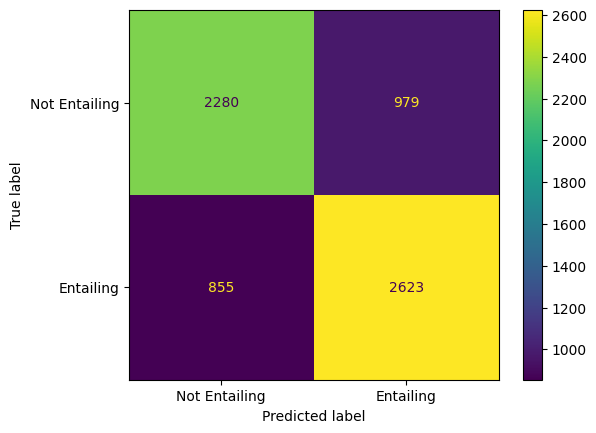

In [26]:
#Confusion matrix
conf_mat = draw_confusion_matrix(true_labels=true, predicted_logits=np.array(predicted_logits))

In [27]:
#Show the most confused samples
df = most_confused_samples(true_logits=to_categorical(true), predicted_logits=np.array(predicted_logits), premises=premises_og, hypotheses=hypotheses_og, num=10)
df

,Premise,Hypothesis,Loss,Predicted Label,True Label
0,He was the first scholar to describe in detail.,He was the first scholar to describe in detail...,11.881137,1,0
1,"La Barredora (""The Sweeper Truck"") is a crimin...","La Barredora (""The Sweeper Truck"") is a crimin...",6.591391,1,0
2,"Today, Italy; tomorrow, who knows?",The trip to Italy will deplete my bank account...,5.636950,1,0
3,Traditional examples of background music inclu...,Traditional examples of background music inclu...,5.580024,1,0
4,Association for Federal Information Resources ...,The Government Executive magazine provides add...,5.529576,0,1
5,"Bryant for introducing the bill, Payne said.","Since the bill had already been introduced, Pa...",5.411198,1,0
6,no i'm sure you know that's one thing you don'...,I don't know whether you know if you should do...,5.375714,1,0
7,It's that interaction with fiscal policy that ...,It's that interaction with the criminal law is...,5.345931,1,0
8,"However, we are so sophisticated psychometrica...",No research can be dissected by methodology al...,5.317111,0,1
9,you want to have that coverage so anyway uh bu...,No press is bad press,5.285258,0,1
